# Bangladeshi Crops Disease Classification Dataset

## Overview

Bangladesh, an agricultural country, relies heavily on crops such as Rice, Corn/Maize, Potato, Wheat, and more. This dataset is curated for the classification of diseases affecting major crops in Bangladesh. The images were sourced from the PlantVillage dataset, Rice Disease Dataset, and Wheat Disease Dataset.

### Classes

The dataset comprises 15 classes, each representing a different crop disease. The classes are as follows:

1. Corn___Common_Rust
2. Corn___Gray_Leaf_Spot
3. Corn___Healthy
4. Corn___Leaf_Blight
5. Invalid
6. Potato___Early_Blight
7. Potato___Healthy
8. Potato___Late_Blight
9. Rice___Brown_Spot
10. Rice___Healthy
11. Rice___Hispa
12. Rice___Leaf_Blast
13. Wheat___Brown_Rust
14. Wheat___Healthy
15. Wheat___Yellow_Rust

### Dataset Details

- Total Files: 31,053
- Number of Classes: 15

### Kaggle Dataset Link

This dataset can be accessed on Kaggle at [Bangladeshi Crops Disease Dataset](https://www.kaggle.com/datasets/nafishamoin/bangladeshi-crops-disease-dataset/data).

## Code Implementation

Below is the code implementation using Google Colab for the Bangladeshi Crops Disease Classification task:

## Getting Data Ready

In [1]:
# The following code allows you to upload files to Google Colab from your local machine.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"callmevicki","key":"1f48b26fc8c5ecb586f9a82d8bed75b7"}'}

In [3]:
# Create a directory named '.kaggle' in the home directory to store Kaggle API credentials.
! mkdir ~/.kaggle

In [4]:
# Copy the Kaggle API credentials file 'kaggle.json' to the '.kaggle' directory in the home folder.
!cp kaggle.json ~/.kaggle/

In [5]:
# Set appropriate permissions (read and write only for the owner) to the Kaggle API credentials file.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download the Bangladeshi Crops Disease Classification dataset from Kaggle using the dataset ID.
!kaggle datasets download -d nafishamoin/bangladeshi-crops-disease-dataset

100% 6.44G/6.45G [05:49<00:00, 21.7MB/s]
100% 6.45G/6.45G [05:49<00:00, 19.8MB/s]


In [ ]:
# Unzip the downloaded dataset file in the specified content directory.
!unzip /content/bangladeshi-crops-disease-dataset.zip

## Importing Dependencies

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from PIL import Image

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


**Set Constants**

In [5]:
IMG_SIZE = 224
CHANNEL = 3
BATCH_SIZE = 32

In [6]:
# Create a TensorFlow image dataset from the provided directory containing crop disease images.

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/CropDisease/Crop___DIsease',
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 31053 files belonging to 15 classes.


In [7]:
# Obtain the class names from the created TensorFlow image dataset.

class_names = dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Leaf_Blight',
 'Invalid',
 'Potato___Early_Blight',
 'Potato___Healthy',
 'Potato___Late_Blight',
 'Rice___Brown_Spot',
 'Rice___Healthy',
 'Rice___Hispa',
 'Rice___Leaf_Blast',
 'Wheat___Brown_Rust',
 'Wheat___Healthy',
 'Wheat___Yellow_Rust']

In [8]:
len(dataset)

971

In [9]:
# Take a subset of the dataset containing the first 200 batches.

dataset = dataset.take(200)

**Plot the sample Images with Their Labels**

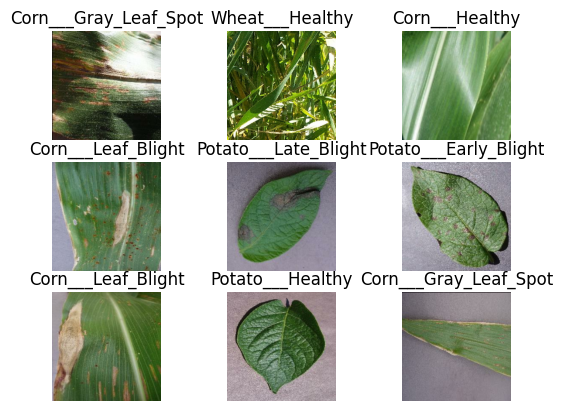

In [10]:
for images, label in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

**Function to Split The Dataset**

In [11]:
def create_data_batch(dataset, test_size=0.1, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=1000):
    """
    Create training, validation, and test datasets from the provided dataset.

    Args:
        dataset (tf.data.Dataset): The input dataset.
        test_size (float): The proportion of the dataset to include in the test split.
        train_split (float): The proportion of the dataset to include in the training split.
        val_split (float): The proportion of the dataset to include in the validation split.
        shuffle (bool): Whether to shuffle the dataset.
        shuffle_size (int): The number of elements used for shuffling.

    Returns:
        train_ds (tf.data.Dataset): The training dataset.
        val_ds (tf.data.Dataset): The validation dataset.
        test_ds (tf.data.Dataset): The test dataset.
    """
    ds_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [12]:
# Create training, validation, and test datasets using the defined function and check their lengths.

train_ds, val_ds, test_ds = create_data_batch(dataset)
len(train_ds), len(val_ds), len(test_ds)

(160, 20, 20)

In [13]:
# Create a Sequential model for rescaling and resizing images using TensorFlow's preprocessing layers.

rescaling_resize = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1.0/255),
    keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

In [14]:
# Create a pre-trained MobileNetV2 model with specified configurations and freeze its layers.

pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='max',
    classes=15,
    classifier_activation="softmax",
)

# Set all layers in the pre-trained model to be non-trainable.
for layer in pre_trained_model.layers:
    layer.trainable = False

In [15]:
# Cache, shuffle, and prefetch the training, testing, and validation datasets.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# Build a sequential model for the Bangladeshi Crops Disease Classification.

INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNEL)
OUTPUT_SHAPE = 15

model = tf.keras.Sequential([
    rescaling_resize,
    pre_trained_model,
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SHAPE, activation="softmax")
])

model.build(INPUT_SHAPE)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (32, 1280)                0         
                                                                 
 dense (Dense)               (32, 250)                 320250    
                                                                 
 dense_1 (Dense)             (32, 15)                  3765      
                                                                 
Total params: 2581999 (9.85 MB)
Trainable params: 324015 (1.24 MB)
Non-trainable params: 2257984 (8.61 MB)
_____________

In [16]:
# Compile the model using the Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy as the metric.

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['acc']
)

In [17]:
# Train the model using the training dataset and validate on the validation dataset for 15 epochs.

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
160/160 [==============================] - 98s 274ms/step - loss: 0.8690 - acc: 0.8029 - val_loss: 0.4645 - val_acc: 0.8250
Epoch 2/15
160/160 [==============================] - 8s 49ms/step - loss: 0.2425 - acc: 0.9102 - val_loss: 0.1655 - val_acc: 0.9453
Epoch 3/15
160/160 [==============================] - 8s 50ms/step - loss: 0.1683 - acc: 0.9383 - val_loss: 0.1296 - val_acc: 0.9578
Epoch 4/15
160/160 [==============================] - 8s 49ms/step - loss: 0.1159 - acc: 0.9551 - val_loss: 0.1390 - val_acc: 0.9469
Epoch 5/15
160/160 [==============================] - 8s 47ms/step - loss: 0.0975 - acc: 0.9629 - val_loss: 0.0911 - val_acc: 0.9688
Epoch 6/15
160/160 [==============================] - 7s 47ms/step - loss: 0.0693 - acc: 0.9756 - val_loss: 0.0759 - val_acc: 0.9719
Epoch 7/15
160/160 [==============================] - 7s 45ms/step - loss: 0.0730 - acc: 0.9734 - val_loss: 0.0730 - val_acc: 0.9734
Epoch 8/15
160/160 [==============================] - 7s 46ms/step 

In [19]:
# Evaluate the model on the test dataset.

model.evaluate(test_ds)

20/20 [==============================] - 49s 41ms/step - loss: 0.2223 - acc: 0.9297


[0.22229304909706116, 0.9296875]

Text(0.5, 1.0, 'Training and Validation Loss')

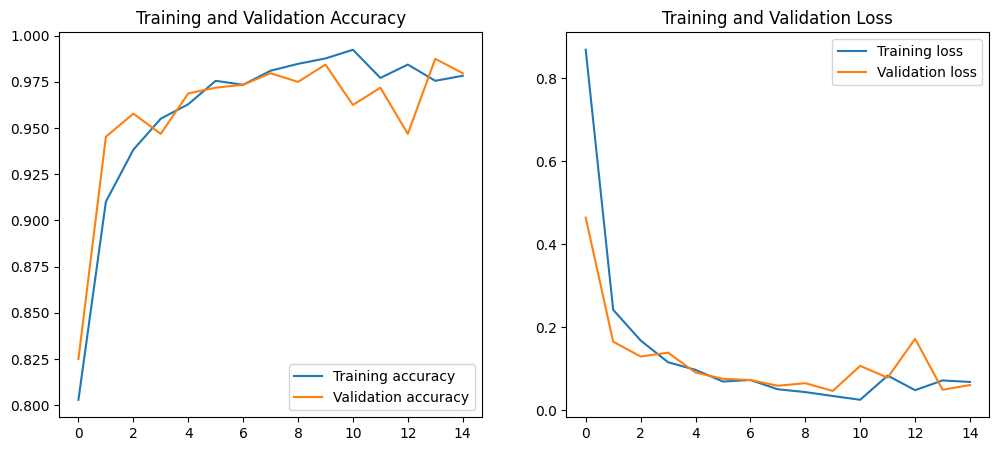

In [18]:
# Visualize training and validation accuracy, as well as training and validation loss over epochs.

loss = history.history["loss"]
acc = history.history["acc"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_acc"]
EPOCHS = 15

# Accuracy for training and validation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

# Loss for training and validation
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend()
plt.title("Training and Validation Loss")

### Save The Model

In [19]:
model.save("crop_disease_classifierV1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Load The Saved Model

In [18]:
from tensorflow.keras.models import load_model

model = load_model("crop_disease_classifierV1.h5")

## Testing With External Images

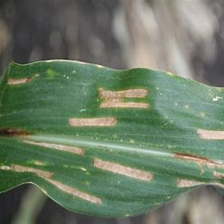

In [31]:
img = Image.open(r"/content/OIP.jpg").resize((224,224))
img

In [32]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_dim = np.expand_dims(img_array, axis=0)
predicted = model.predict(img_dim)
print(f"predicted_image: {class_names[np.argmax(predicted)]}")

1/1 [==============================] - 0s 21ms/step
predicted_image: Corn___Gray_Leaf_Spot
